# Header
Author: Wang Dong  
Email: wang0dong@gmail.com, dwang2014@my.fit.edu  
Date: 10/27/2023  

In [1]:
'''
Libraries 
'''
import os
import imageio.v2 as imageio
import json
import numpy as np
import cv2
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
from mpl_toolkits import mplot3d
import math
import open3d as o3d

# plt.style.use('seaborn-poster')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
'''
function definition
'''

# Parses the json file
def json_read(filename):
    try:
        with open(os.path.abspath(filename)) as f:    
            data = json.load(f)
        return data
    except:
        raise ValueError("Unable to read JSON {}".format(filename))

# Define the path to the MP4 video file
def read_frame(video_path, frame_number_to_read):

    # Create a video reader object using imageio
    video_reader = imageio.get_reader(video_path)
    frame = video_reader.get_data(frame_number_to_read)
#     # Opencv uses BGR so we convert to RGB here 
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
    # Close the video reader
    video_reader.close()
    return frame


def plot2Dimage(projresult, axis2Dresult, imgresult):
    axs_xlimit = [[1000,1800], [400,900], [500,1000],[900,1700],[1000,1700],[200,900]]
    axs_ylimit = [[100,800],[100,500],[300,600],[0,700],[100,700],[100,600] ]
    
    #define subplots
    fig, axs = plt.subplots(2, 3, figsize=(12,8))
    fig.tight_layout()
    warnings.filterwarnings("ignore")

    # plot result
    index = 0
    for axi in range (0,2):
        for axj in range (0,3):
            img = imgresult[index]
            proj = projresult[index]
            axis2D = axis2Dresult[index]
            # plot the img
            axs[axi,axj].imshow((img))

            # Plot the x, y and z axes vector on image
            x_start = axis2D[0][0]
            y_start = axis2D[0][1]
            x_end = axis2D[1][0]
            y_end = axis2D[1][1]
            # x axes vector
            axs[axi,axj].arrow(x_start, y_start, x_end - x_start, y_end - y_start, \
                               head_width=10, head_length=20, fc='red', ec='red')
            x_end = axis2D[2][0]
            y_end = axis2D[2][1]
            # y axes vector
            axs[axi,axj].arrow(x_start, y_start, x_end - x_start, y_end - y_start, \
                               head_width=10, head_length=20, fc='green', ec='green')
            x_end = axis2D[3][0]
            y_end = axis2D[3][1]
            # z axes vector
            axs[axi,axj].arrow(x_start, y_start, x_end - x_start, y_end - y_start, \
                               head_width=10, head_length=20, fc='blue', ec='blue')

            # plot projected point cloud
            axs[axi,axj].scatter(proj[:,0], proj[:,1], c='g', marker='o', s = 2)
            # set up the x and y limit to adjust figure postion
            axs[axi,axj].set_xlim(axs_xlimit[index][0],axs_xlimit[index][1])
            axs[axi,axj].set_ylim(axs_ylimit[index][1],axs_ylimit[index][0])
            axs[axi,axj].set_title('Camear %i view' %index)

            index +=1

    plt.tight_layout()
    plt.show()

def pntchker(point3D):
    chker = 1
    for idx in range (len(view_list)):
        imgmask = masks[idx]
        R = np.array(calibration[view_list[idx]]['R'])
        rvec = cv2.Rodrigues(R)[0]
        t = np.array(calibration[view_list[idx]]['t'])
        K = np.array(calibration[view_list[idx]]['K'])
        dist = np.array(calibration[view_list[idx]]['dist'])
        proj = cv2.projectPoints(point3D, rvec, t, K, dist)[0].reshape(-1,2)[0]
        # fall outside of Silhouette Mask, set checker to 0 and break the loop
#         print(imgmask.shape)
#         print(math.floor(proj[1]))
#         print(math.floor(proj[0]))
#         print(imgmask[math.floor(proj[1]-1),math.floor(proj[0])-1])

        # fall outside of image, set checker to 0 and break the loop 
        try:
            flag = imgmask[math.floor(proj[1]-1),math.floor(proj[0])-1]
        except IndexError:
            chker = 0
            break
        # fall outside of Silhouette Mask but inside image, set checker to 0 and break the loop
        if(flag):
            chker = 0
            break

    return chker    

In [4]:
%matplotlib qt
'''
Define 3D Cubeic point cloud and axes 
'''
pnt_num = 10
scaler = 0.8
# Define the dimensions of the grid
x_low = 1.5
x_high = 3
y_low = -0.75
y_high = 0.75
z_low = 0
z_high = 2
x_range = np.linspace(x_low, x_high, pnt_num) #(1,3)
y_range = np.linspace(y_low, y_high, pnt_num) # (-1, 1)
z_range = np.linspace(z_low, z_high, pnt_num) 

# Create a grid of 3D points
x, y, z = np.meshgrid(x_range, y_range, z_range)

# Flatten the grid into 1D arrays
x = x.flatten()
y = y.flatten()
z = z.flatten()

virtualcube = np.concatenate((x.reshape(len(x),1), y.reshape(len(y),1), z.reshape(len(z),1)), axis = 1)
# Define 3D axes 
origin = np.array([0,0,0])*scaler
axis_x = np.array([1,0,0])*scaler
axis_y = np.array([0,1,0])*scaler
axis_z = np.array([0,0,1])*scaler
axis3D = np.concatenate(([origin], 
                        [axis_x], 
                        [axis_y], 
                        [axis_z]), axis = 0)

# # Create a 3D figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the evenly distributed 3D points
# ax.scatter(x, y, z, c='b', marker='o', s=1)
# # Set axis labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# # Show the 3D point cloud
# plt.show()

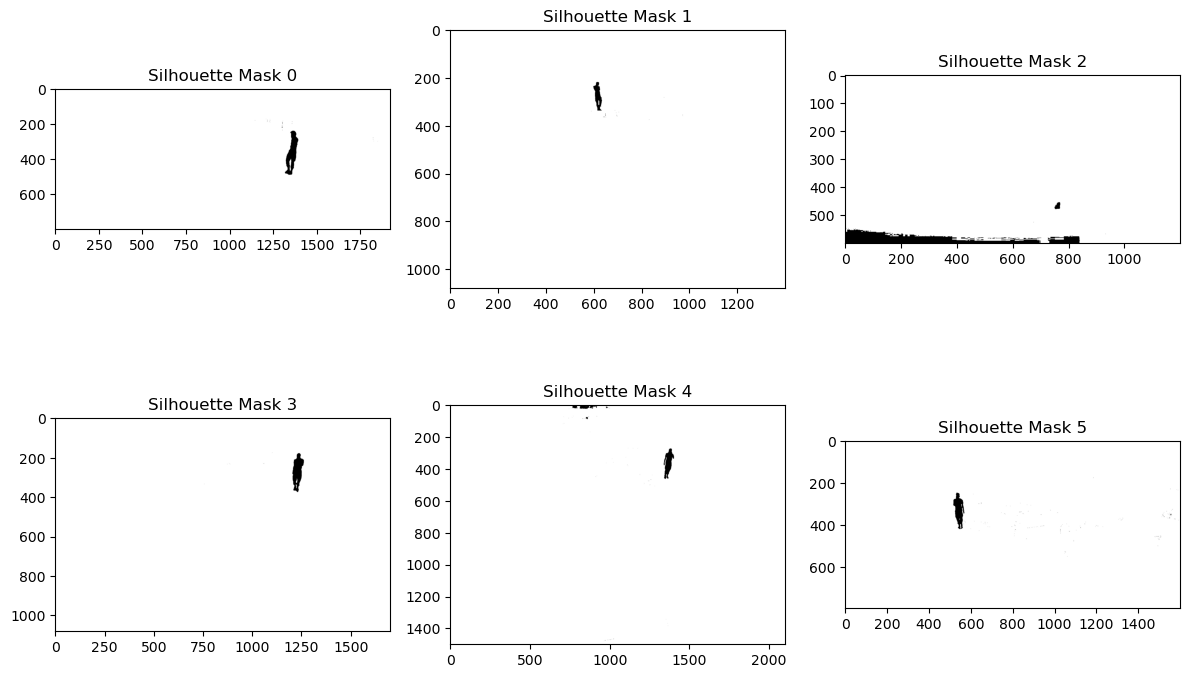

In [5]:
%matplotlib inline
'''
Create image mask
'''
# read inputs
view_list = ['3_2','3_4','6_1','6_3','6_4','6_5']
frameidx = 855 # 
lastframe = 16800-1
# silhouettes = []
masks =[]

# read videos and save the unobstructed images
# for idx in range(len(view_list)):
#     image = read_frame("{}.mp4".format(view_list[idx]), frameidx)
#     imageio.imwrite("sample_image_{}.png".format(view_list[idx]), image)
#     imgs.append(image)   

# or read frames
for idx in range(len(view_list)):
    silhouettes_path = "sample_image_{}_silhouette.bmp".format(view_list[idx])
    img_path = "sample_image_{}.bmp".format(view_list[idx])

# create mask image
    silhouette = cv2.imread(silhouettes_path, cv2.IMREAD_UNCHANGED) #IMREAD_GRAYSCALE
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    # Perform the subtraction
    background = cv2.absdiff(image, silhouette)
    background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

    # Set the threshold value
    threshold_value = 0
    _, mask = cv2.threshold(background, threshold_value, 255, cv2.THRESH_BINARY)  

#     # Optionally, apply morphological operations for noise reduction or mask refinement
#     kernel = np.ones((1, 1), np.uint8)
#     mask = cv2.erode(mask, kernel, iterations=1)
#     mask = cv2.dilate(mask, kernel, iterations=1)
    
    masks.append(mask)

'''
# read image and background (last frame)
for idx in range(len(view_list)):
    image = read_frame("{}.mp4".format(view_list[idx]), frameidx)# read frames
    background = read_frame("{}.mp4".format(view_list[idx]), lastframe)# read background
    mask = cv2.absdiff(image, background)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # Set the threshold value
    mask = cv2.bitwise_not(mask)
    threshold_value = 230
    _, mask = cv2.threshold(mask, threshold_value, 255, cv2.THRESH_BINARY)  

    # Optionally, apply morphological operations for noise reduction or mask refinement
    kernel = np.ones((1, 1), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=1)

    masks.append(mask)
'''
    
# plot result
#define subplots
fig, axs = plt.subplots(2, 3, figsize=(12,8))
fig.tight_layout()
warnings.filterwarnings("ignore")
index = 0
for axi in range (0,2):
    for axj in range (0,3):
        img = masks[index]
#             axs[axi,axj].invert_yaxis()
        # plot the img
#             axs[axi,axj].imshow(np.flip(img))
        axs[axi,axj].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # plot projected axes
        axs[axi,axj].set_title('Silhouette Mask %i' %index)
        index +=1

plt.tight_layout()
plt.show()



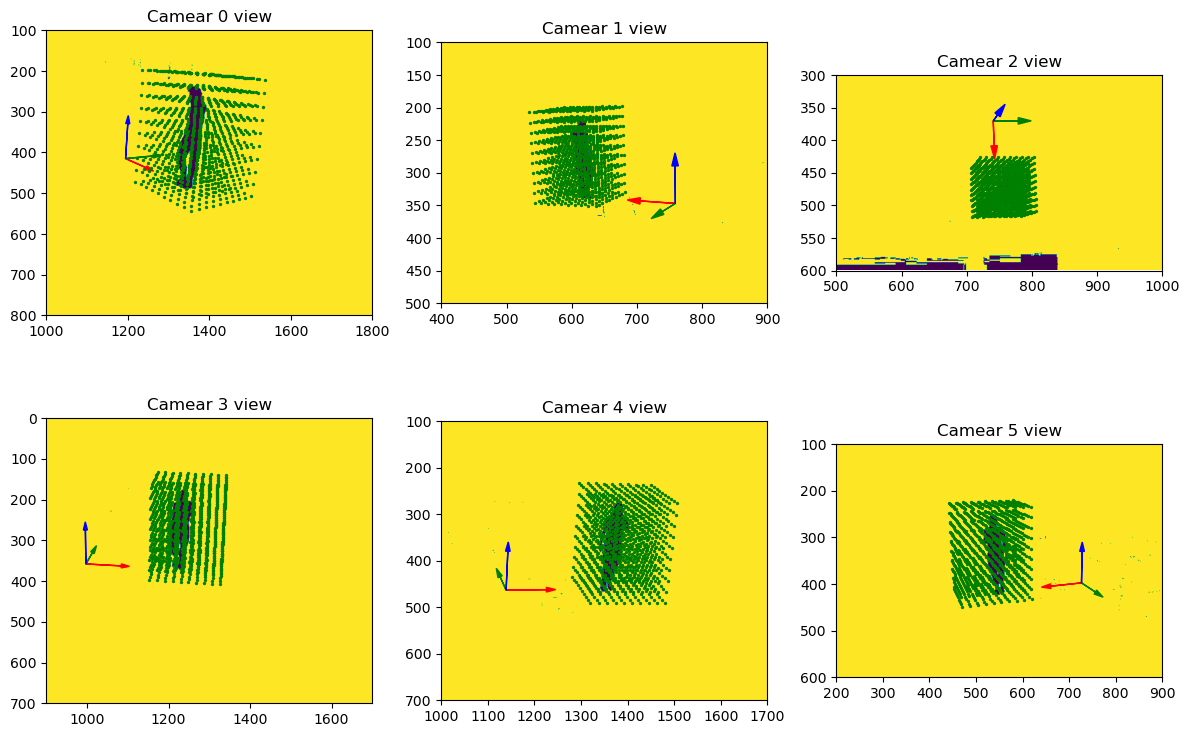

In [6]:
'''
project 3D Cubeic point cloud on the associate image mask
'''
%matplotlib inline
calibration = json_read("calibration.json")
trajectories = json_read("trajectories.json")
projresult = []
axis2Dresult = []
for idx in range (len(view_list)):
    img = masks[idx]
    R = np.array(calibration[view_list[idx]]['R'])
    rvec = cv2.Rodrigues(R)[0]
    t = np.array(calibration[view_list[idx]]['t'])
    K = np.array(calibration[view_list[idx]]['K'])
    dist = np.array(calibration[view_list[idx]]['dist'])
    proj = cv2.projectPoints(virtualcube, rvec, t, K, dist)[0].reshape(-1,2)
    projresult.append(proj)
    axis2D = cv2.projectPoints(axis3D, rvec, t, K, dist)[0].reshape(-1,2)
    axis2Dresult.append(axis2D)
plot2Dimage(projresult, axis2Dresult, masks)

In [7]:
'''
space carving
'''
# Define the dimensions of the voxel volume (e.g., 10x10x10)
# upper body carving
sf = 200
step = 5
x_range = [int(x_low*sf), int(x_high*sf)]
y_range = [int(y_low*sf), int(y_high*sf)]
z_range = [int(0.4*sf), int(z_high*sf)]
# Create a voxel volume with all values initialized to zero
voxel_volume_upper = np.zeros((x_range[1]-x_range[0], y_range[1]-y_range[0], z_range[1]-z_range[0]), dtype=int)

for i in range(x_range[0], x_range[1], step):
    for j in range(y_range[0], y_range[1], step):
        for k in range(z_range[0], z_range[1], step):
            x = i/sf
            y = j/sf
            z = k/sf
            point3D = np.array([x,y,z])
            # Is point3D inside silhouette? If YES then label voxel as 1.
            inside = pntchker(point3D)
            if inside:
                voxel_volume_upper[i-x_range[0],j-y_range[0],k-z_range[0]] = 1

# lower body carving
sf = 200
step = 1
x_range = [int(x_low*sf), int(x_high*sf)]
y_range = [int(y_low*sf), int(y_high*sf)]
z_range = [int(z_low*sf), int(0.4*sf)]
# Create a voxel volume with all values initialized to zero
voxel_volume_lower = np.zeros((x_range[1]-x_range[0], y_range[1]-y_range[0], z_range[1]-z_range[0]), dtype=int)
for i in range(x_range[0], x_range[1], step):
    for j in range(y_range[0], y_range[1], step):
        for k in range(z_range[0], z_range[1], step):
            x = i/sf
            y = j/sf
            z = k/sf
            point3D = np.array([x,y,z])
            # Is point3D inside silhouette? If YES then label voxel as 1.
            inside = pntchker(point3D)
            if inside:
                voxel_volume_lower[i-x_range[0],j-y_range[0],k-z_range[0]] = 1


In [8]:
'''
point cloud plot
'''
# concatenate upper and lower body voxel data
voxel_volume = np.concatenate((voxel_volume_lower, voxel_volume_upper), axis=2)
# Define the label to display
label_to_display = 1
# Create a mask for the voxels with the specified label
# mask = load_original_arr == label_to_display
mask = voxel_volume == label_to_display
# Extract the coordinates of the voxels with the specified label
x, y, z = np.where(mask)

# Construct the point cloud array
point_cloud_data = np.concatenate((x.reshape(len(x),1), y.reshape(len(y),1), z.reshape(len(z),1)), axis = 1)
# Convert the NumPy array to an Open3D PointCloud object
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(point_cloud_data)
# T_recon = o3d.geometry.TriangleMesh()
# Visualize the point cloud
# Set the size of the window
width = 800
height = 600
# o3d.visualization.draw_geometries([point_cloud])
# Draw the geometry
o3d.visualization.draw_geometries([point_cloud], window_name="3D Solider", width=width, height=height)



# alpha = 0.04
# tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(point_cloud)
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(point_cloud, alpha, tetra_mesh, pt_map)
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

# # Compute normals for the point cloud
# point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# # Perform Poisson surface reconstruction with normals
# surface_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=6)
# # Visualize the reconstructed surface
# o3d.visualization.draw_geometries([surface_mesh])